# Analyze A/B Test Results

A/B testing is a powerful tool for data-driven business decisions. If you've finished running an A/B test with two variants, you can use this template to analyze and visualize your results. And of course, to find out if your results are significant 🤞! If you want to learn more about designing A/B tests and the statistics behind them, check out DataCamp's [Customer Analytics and A/B Testing in Python](https://app.datacamp.com/learn/courses/customer-analytics-and-ab-testing-in-python). 

### 1. Loading and checking the data

To use this template, your data must have a row for each user who's participated in the test and at least these four columns:
- "uid": the unique identifier of the user. This column should have no duplicates.
- "date": the date of the user's visit during the experiment.
- "group": which of the two variants the user received, e.g., "Free Trial"/"No Free Trial" or "Control"/"Treatment".
- "converted": whether the user converted (0 = no, 1 =  yes), e.g., whether the user signed up for the product or made a purchase.

The placeholder dataset in this template is from a 2.5 week long A/B experiment with two groups called "A" and "B".

In [1]:
import pandas as pd
import numpy as np
import scipy as sci
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# Load in your results as a dataframe
df = pd.read_csv("data/ab_test_results.csv")
df.head()

,date,group,converted,uid
0,2020-08-15,A,0,397466
1,2020-08-15,A,0,440843
2,2020-08-15,B,0,370065
3,2020-08-15,B,0,370059
4,2020-08-15,B,0,370058


If the following three lines of code don't print out `True`, you will need to clean up your dataset before using the rest of this template. 

In [2]:
# Are all values in uid unique?
print(df["uid"].is_unique)

# Are there only two types of groups?
print(df["group"].nunique() == 2)

# Are there only 1s & 0s in converted?
print((df["converted"].unique() == [0, 1]).all())

True
True
True


Now, let's check that the two groups are about the same size:

A    50.971436
B    49.028564
Name: group, dtype: float64


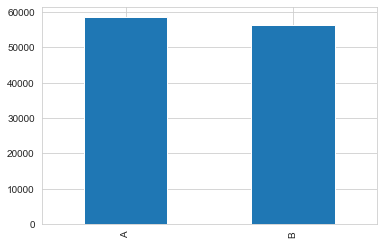

In [3]:
# Print out the percentage of users in each group
print(df["group"].value_counts() / df["group"].count() * 100)

# Plot the number of users in each group
df["group"].value_counts().plot(kind="bar");

### 2. Visualizing conversion rate over time

Below, we plot the daily conversion rate segmented by the two groups. This is helpful to track the progress of the experiment over time and get an initial sense of the test results (but this never replaces a test of statistical significance!).

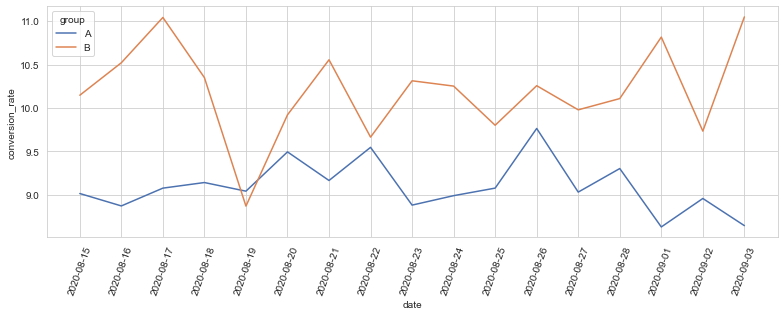

In [4]:
# Calculate the conversion rate by group and date
cr_time = df.groupby(by=["date", "group"], as_index=False)
cr_time = cr_time.agg({"converted": ["count", "sum"]})
cr_time["conversion_rate"] = (
    cr_time.converted["sum"] / cr_time.converted["count"]
) * 100

# Plot conversion rate over time segmented by group
fig, ax = plt.subplots(figsize=(11, 4.5))
sns.lineplot(data=cr_time, x="date", y="conversion_rate", hue="group", palette="deep")
plt.xticks(rotation=70)
plt.tight_layout()

### 3. Testing and interpreting statistical significance

Now it's time to see if the results were significant! To do so, we'll use calculations from chapter four of [Customer Analytics and A/B Testing in Python](https://app.datacamp.com/learn/courses/customer-analytics-and-ab-testing-in-python), which is a useful reference if you want to learn more.

To calculate the statistical significance, we need to find each group's size and conversion rate throughout the entire experiment period.

In [5]:
# Get names of groups 
a,b = df.group.unique()

# Get the size of each group
a_size = df['group'].value_counts()[0]
b_size = df['group'].value_counts()[1]

# Calculate the conversion rate of each group
cr = df.groupby(by=['group'], as_index=False)
cr = cr.agg(
    {'converted': ['count', 'sum']})
cr['conv'] = (cr.converted['sum'] / cr.converted['count'])
a_conv = cr[cr.group == a].conv[0]
b_conv = cr[cr.group == b].conv[1]

# Print the size and conversion rate of each group
print("Group", a, ":", a_size, a_conv) 
print("Group", b, ":", b_size, b_conv)

Group A : 58583 0.09096495570387314
Group B : 56350 0.1020053238686779


Now, we can calculate the p-value and use it to decide if results are significant.

In [6]:
# Define a function to calculate and interpret the p-value
def get_pvalue(con_conv, test_conv, con_size, test_size):
    lift = -abs(test_conv - con_conv)
    scale_one = con_conv * (1 - con_conv) * (1 / con_size)
    scale_two = test_conv * (1 - test_conv) * (1 / test_size)
    scale_val = (scale_one + scale_two) ** 0.5
    p_value = 2 * stats.norm.cdf(lift, loc=0, scale=scale_val)
    if p_value >= 0.05:
        msg = "Not Significant"
    else:
        msg = "Significant Result"
    return p_value, msg


# Calculate the p-value of the experiment
p_value = get_pvalue(a_conv, b_conv, a_size, b_size)
print("p-value:", p_value)

p-value: (2.3712097932400415e-10, 'Significant Result')


We can plot the test and control conversion rates as distributions. Visualizing the overlap or lack thereof helps intuit the distinctness of the conversion rates between the two groups.

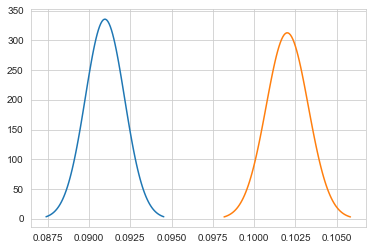

In [7]:
# Compute the variance
a_var = (1 - a_conv) * a_conv / a_size
b_var = (1 - b_conv) * b_conv / b_size

# Compute the standard deviations
a_sd, b_sd = a_var ** 0.5, b_var ** 0.5

# Create the range of x values
a_line = np.linspace(a_conv - 3 * a_sd, a_conv + 3 * a_sd, 100)
b_line = np.linspace(b_conv - 3 * b_sd, b_conv + 3 * b_sd, 100)

# Plot the distribution
plt.plot(a_line, norm.pdf(a_line, a_conv, a_sd))
plt.plot(b_line, norm.pdf(b_line, b_conv, b_sd))
plt.show()